In [8]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import qmc
from typing import Dict

# Low-discrepancy sequences

The **discrepancy** of a sequence is a measure of how evenly spread the points are in space. A sequence has a low discrepancy if the proportion of points falling into a set $X$ is close to the measure of $X$, so that spatial uniformity or homogeneity occurs.

Let $x = \left(x_1, \ldots, x_n\right)$ be a sequence with $x_i \in \mathbb{R}^d$. Then, the discrepancy of $x$ is defined as

$$
D_n(x) = \sup_{[a, b)} \left\vert \frac{\vert x \in [a, b)\vert}{n} - \prod_{i=1}^d (b_i - a_i)\right\vert,
$$

where the supremum is taken over all $d$-dimensional intervals of the form $[a, b) = \{x \in \mathbb{R}^d \vert a_i \leq x_i < b_i\}$ with $a \leq b$. There are several ways to construct low-discrepancy sequences, which are all deterministic methods. Therefore they are often referred to as **quasi-random** sequences, as they are not really random, but often used in Monte Carlo type techniques replacing the (pseudo)-random sequences.

### Example 
Scipy's `scipy.stats.qmc` provides functionalities for generating low-discrepancy sequences as well as calulating the discrepancy. For illustration, take a look at the following example:

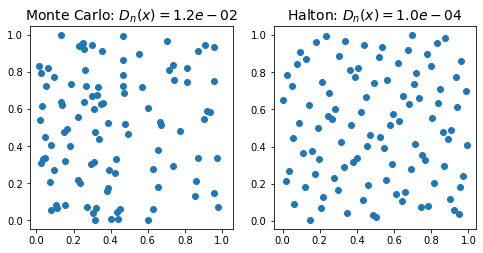

In [9]:
monte_carlo = np.random.default_rng().random((100, 2))
mc_discr = qmc.discrepancy(monte_carlo)

halton = qmc.Halton(d=2).random(100)
halton_discr = qmc.discrepancy(halton)

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].scatter(*monte_carlo.T)
axs[0].set_title(rf"Monte Carlo: $D_n(x) = {mc_discr:.1e}$", size=14)
axs[1].scatter(*halton.T)
axs[1].set_title(rf"Halton: $D_n(x) = {halton_discr:.1e}$", size=14)

for ax in axs:
    ax.axis("square")

On the left you see a sequence of Monte Carlo points and on the right a typical low discrepancy sequence, the *Halton sequence*. Note the more even distribution in space, i.e. the lower discrepancy.

## Approximating $\pi$ using not so random sequences

Let's approximate $\pi$ by using the Monte Carlo method and count how many points land in the quarter of the unit circle, which should approximate $\frac{\pi}{4}$. Using a low-discrepancy sequence in this case, i.e. a not really random sequence of numbers, is known as the **Quasi-Monte Carlo** method. We will see that the smaller discrepancy leads to faster convergence as the space filled faster.

In [10]:
def get_sequences(sample_size: int, discrepancy: bool = False) -> Dict["str", dict]:
    samples = {
        "Monte Carlo": {
            "sampler": np.random.default_rng(),
        },
        "Latin Hypercube": {
            "sampler": qmc.LatinHypercube(d=2),
        },
        "Halton": {
            "sampler": qmc.Halton(d=2),
        },
        "Sobol": {
            "sampler": qmc.Sobol(d=2),
        },
    }

    for name, val in samples.items():
        smplr = val["sampler"]

        if name == "Monte Carlo":
            val["sequence"] = smplr.random((sample_size, 2))
        else:
            val["sequence"] = smplr.random(sample_size)
        
        if discrepancy:
            val["discrepancy"] = qmc.discrepancy(val["sequence"])
    
    return samples

In [11]:
n = 5_000
discrepancy = True

samples = get_sequences(sample_size=n, discrepancy=discrepancy)

Discrepancies:
--------------
Monte Carlo      2.941e-05
Latin Hypercube  4.163e-06
Halton           1.046e-07
Sobol            9.710e-08


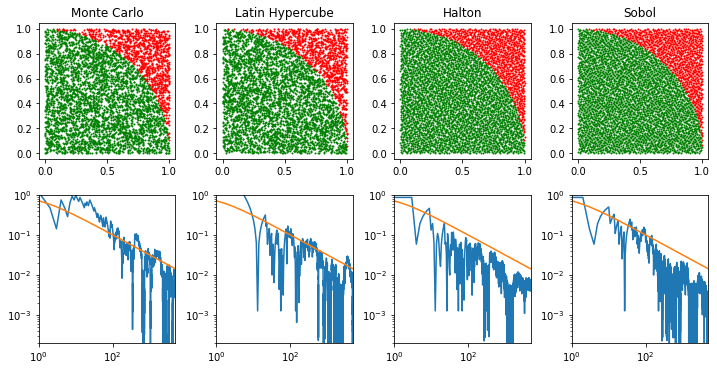

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
ax = ax.ravel()
plt.subplots_adjust(wspace=0.3)

if discrepancy:
    print("Discrepancies:\n--------------")

for i, (name, val) in enumerate(samples.items()):
    sample = val["sequence"]
    x, y = sample.T
    inside = x ** 2 + y ** 2 < 1

    ax[i].scatter(x[inside], y[inside], c="g", s=1)
    ax[i].scatter(x[~inside], y[~inside], c="r", s=1)
    ax[i].axis("square")
    ax[i].set_title(name)
    
    err = np.abs(4 * inside.cumsum() / (np.arange(n) + 1) - np.pi)
    ax[i+4].loglog(err)
    ax[i+4].loglog(1 / np.sqrt(np.arange(n) + 1))
    ax[i+4].set_xlim([1, n])
    ax[i+4].set_ylim([1 / n, 1])
    
    if discrepancy:
        x = val["discrepancy"]
        print(f"{name:<16} {x:.3e}")

The first row of plots shows the distribution of samples in the unit square. One can clearly observe the discrepancy differing in the four methods. Also the convergence happens much faster for the Quasi-Monte Carlo methods using the Halton and Sobol sequence.

**Note** the orange line representing the convergence rate of the standard Monte Carlo method, which is $\frac{1}{\sqrt{N}}$.

### Experimental converge order

In order to compare the convergence rates, we use 50 batches of size 5000 each and average the error of approximating $\pi$.

In [13]:
n = 5_000
n_batches = 50

err = np.zeros((n, 4))
for _ in range(n_batches):
    samples = get_sequences(sample_size=n)
    for i, (name, val) in enumerate(samples.items()):
        sample = val["sequence"]
        x, y = sample.T
        inside = x ** 2 + y ** 2 < 1

        err_ = np.abs(4 * inside.cumsum() / (np.arange(n) + 1) - np.pi)
        err[:, i] += err_
err /= n_batches

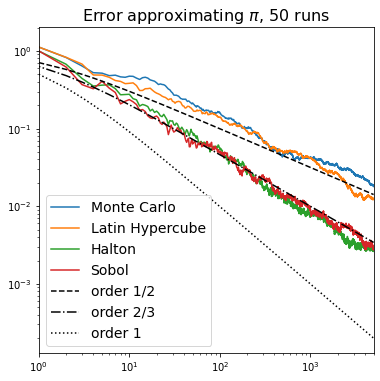

In [14]:
fig = plt.figure(figsize=(6, 6))
plt.loglog(err, label=samples.keys())
plt.loglog(1 / (np.arange(n) + 1) ** (1/2), "k--", label="order 1/2")
plt.loglog(1 / (np.arange(n) + 1) ** (2/3), "k-.", label="order 2/3")
plt.loglog(1 / (np.arange(n) + 1), "k:", label="order 1")
plt.xlim([1, n])
plt.title(r"Error approximating $\pi$, 50 runs", size=16)
plt.legend(fontsize=14);